In [1]:
using PyPlot

INFO: Loading help data...


##### Plot functions

In [2]:
function draw_arrow(i::Int64, j::Int64, action::Symbol, dim::(Int64, Int64), changed::Bool)
    NX = dim[2]
    NY = dim[1]+1
    offset = 0.1
    if action == :north
        arrow(i-0.5, NY-j-0.9, 0, +0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    elseif action == :south
        arrow(i-0.5, NY-j-0.1, 0, -0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    elseif action == :east
        arrow(i-0.9, NY-j-0.5, +0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    elseif action == :west
        arrow(i-0.1, NY-j-0.5, -0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    end
end

function plot_data(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64}, old_policy::Any)
    s = (size(V)[2]*0.6, size(V)[1] .* 0.25)
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    xlim([1,size(V)[2]-1])
    ylim([1,size(V)[1]-1])

    for i = 1:size(V)[2]-2
        plot([i,i],[0,size(V)[1]], color="black")
    end
    for i = 1:size(V)[1]-2
        plot([0,size(V)[2]], [i,i], color="black")
    end
    
    for i = 2:size(V)[1]-1
        for j = 2:size(V)[2]-1
            changed = false
            if old_policy != nothing
                changed = (policy[i, j] != old_policy[i,j])
            end
            draw_arrow(j, i, policy[i, j], size(V), changed)
        end
    end
    subplot(122)
    colorbar(imshow(V[2:end-1,2:end-1], interpolation="none"))
    xticks([])
    yticks([])
    c_values = [v>-100?v:0 for v in V]
    clim([minimum(c_values),maximum(c_values)])
end

plot_data (generic function with 1 method)

##### Convert definition to maze representation

In [3]:
function convert_string_to_string_array(s::String)
    index = 1
    while s[index] == ' ' || s[index] == '\n'
        index = index + 1
    end
    maze = nothing
    row = []
    for i=index:length(s)
        if s[i] == '\n'
            if maze == nothing
                maze = row
            else
                maze = hcat(maze, row)
            end
            row = []
        else
            row = [row, s[i]]
        end
    end
    return maze'
end



function create_experiment_setup(definition::String)
    actions = [:north, :east, :south, :west, :none]

    maze   = convert_string_to_string_array(maze_definition)
    V      = zeros(size(maze))
    policy = reshape([actions[int64(ceil(rand() * (length(actions)-1)))] for i = 1:length(maze)], size(maze))

    for i=1:length(maze)
        if maze[i] in ['#', 'T']
            V[i] = state_reward_function[maze[i]]
            policy[i] = :none
        end
    end

    return maze, policy, V
end

create_experiment_setup (generic function with 1 method)

# Value iteration

In [4]:
function policy_iteration!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64}, first::Bool)
    for i = 2:size(maze)[1]-1
        for j = 2:size(maze)[2]-1
            if maze[i,j] == ' '
                possible_actions = []
                action_values = []
                if maze[i-1,j] != '#'
                    possible_actions = [possible_actions, :north]
                    action_values    = [action_values, V[i-1, j]]
                end
                if maze[i+1,j] != '#'
                    possible_actions = [possible_actions, :south]
                    action_values    = [action_values, V[i+1, j]]
                end

                if maze[i,j-1] != '#'
                    possible_actions = [possible_actions, :west]
                    action_values    = [action_values, V[i, j-1]]
                end
                if maze[i,j+1] != '#'
                    possible_actions = [possible_actions, :east]
                    action_values    = [action_values, V[i, j+1]]
                end
                best_action_value = maximum(action_values)
                possible_actions = possible_actions[findin(action_values,best_action_value)]
                action = possible_actions[int(ceil(rand() * length(possible_actions)))] # random
                policy[i,j] = action
            end
        end
    end
end

function value_iteration!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64}, first::Bool)
    new_values = copy(V)
    γ = 0.9
    iterations = 0
    for i = 2:size(V)[1] - 1
        for j = 2:size(V)[2] - 1
            if maze[i,j] == ' '
                values = [γ * V[i-1,j] - 1.0, γ * V[i+1,j] - 1.0, γ * V[i,j+1] - 1.0, γ * V[i,j-1] - 1.0]
                new_values[i,j] = maximum(values)
            end
        end
    end
    δ = maximum(abs(V .- new_values))
    println("δ = $δ")
    for i=2:size(V)[1] - 1
        for j=2:size(V)[2] - 1
            V[i,j] = new_values[i,j]
        end
    end
    #    println("Nr. of iterations $iterations, error $δ")
    old_policy = copy(policy)
    policy_iteration!(maze, policy, V, first)
    if first == true
        plot_data(maze, policy, V, nothing)
    else
        plot_data(maze, policy, V, old_policy)
    end
end

value_iteration! (generic function with 1 method)

δ = 1.0


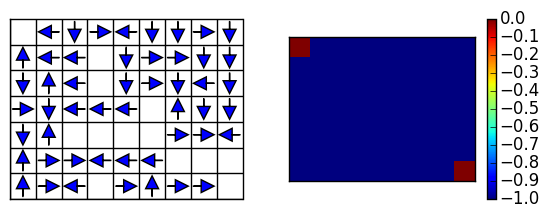

In [5]:
maze_definition = "
###########
#T        #
#   #     #
#   #     #
#     #   #
#  ####   #
#      ####
#   #    T#
###########
"

state_reward_function = ['T' => 0.0, '#' => -100];

maze, policy, V = create_experiment_setup(maze_definition);
value_iteration!(maze, policy, V, true)

δ = 0.8999999999999999


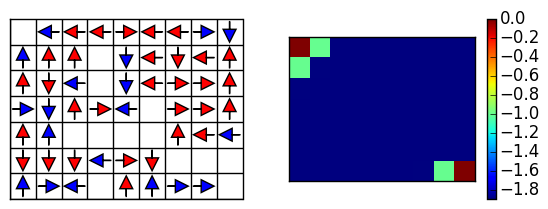

In [6]:
value_iteration!(maze, policy, V, false)

δ = 0.81


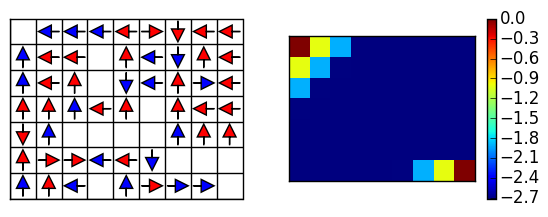

In [7]:
value_iteration!(maze, policy, V, false)

δ = 0.7290000000000001


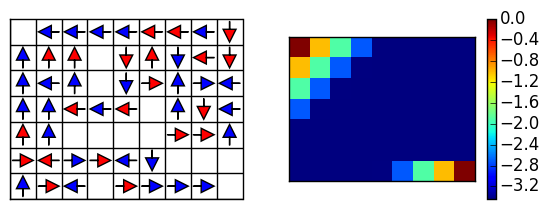

In [8]:
value_iteration!(maze, policy, V, false)

δ = 0.6561000000000003


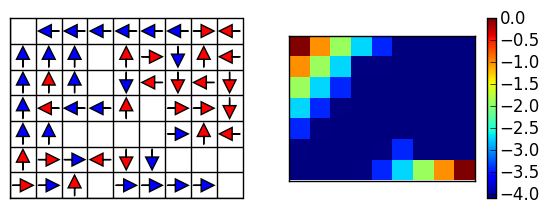

In [9]:
value_iteration!(maze, policy, V, false)

δ = 0.59049


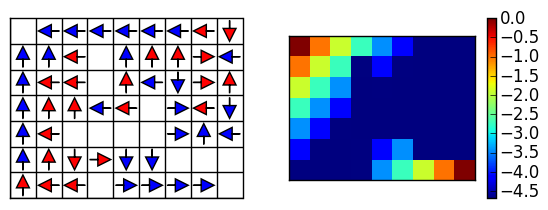

In [10]:
value_iteration!(maze, policy, V, false)

δ = 0.531441


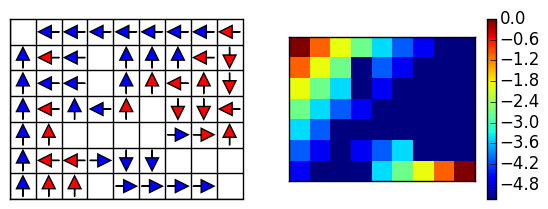

In [11]:
value_iteration!(maze, policy, V, false)

δ = 0.47829690000000014


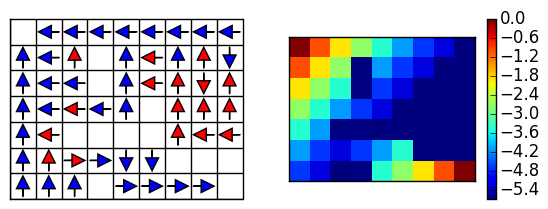

In [12]:
value_iteration!(maze, policy, V, false)

δ = 0.43046720999999977


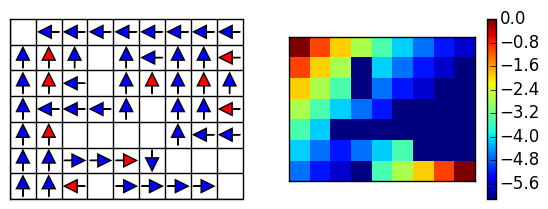

In [13]:
value_iteration!(maze, policy, V, false)

δ = 0.38742048900000015


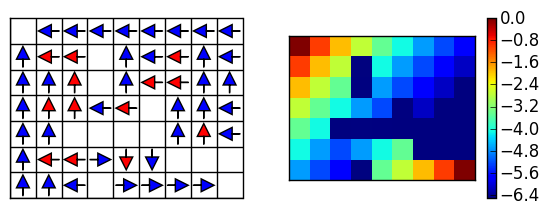

In [14]:
value_iteration!(maze, policy, V, false)

δ = 0.3486784401000005


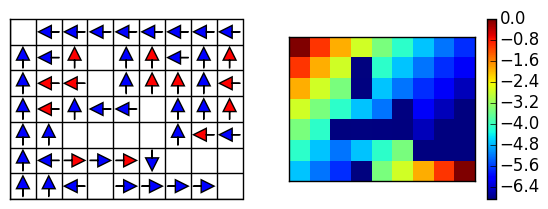

In [15]:
value_iteration!(maze, policy, V, false)

δ = 0.3138105960899997


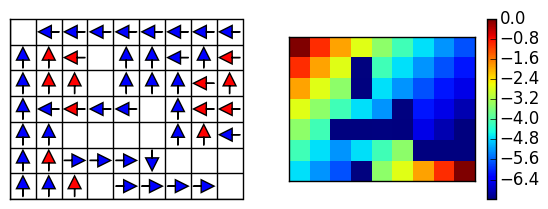

In [16]:
value_iteration!(maze, policy, V, false)

δ = 0.0


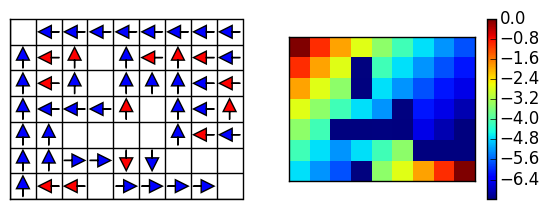

In [17]:
value_iteration!(maze, policy, V, false)

δ = 0.0


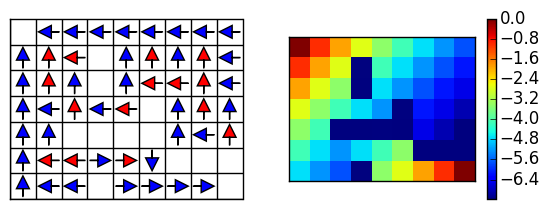

In [18]:
value_iteration!(maze, policy, V, false)

δ = 0.0


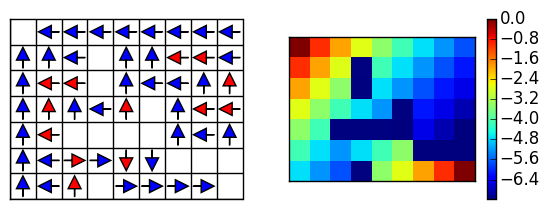

In [19]:
value_iteration!(maze, policy, V, false)

δ = 0.0


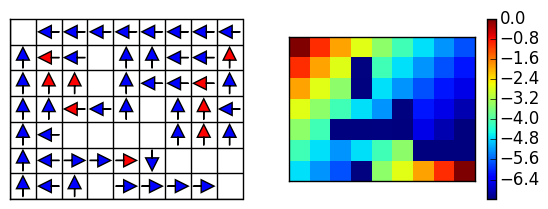

In [20]:
value_iteration!(maze, policy, V, false)

δ = 0.0


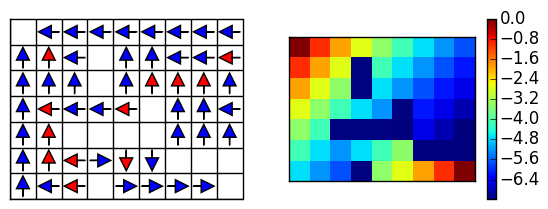

In [21]:
value_iteration!(maze, policy, V, false)